Install

In [1]:
!pip install --upgrade pandas
!pip install --upgrade gensim
!pip install --upgrade pythainlp
!pip install --upgrade pyLDAvis
!pip install text2emotion
!pip install fairseq
!pip install sacremoses sentencepiece
!pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip

  Using cached https://github.com/PyThaiNLP/pythainlp/archive/dev.zip


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

import pandas as pd
import numpy as np
import re
import string
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import pythainlp 
from pythainlp.translate import EnThTranslator, ThEnTranslator
from pythainlp.translate import download_model_all
from pythainlp.corpus.common import *
from pythainlp.util import normalize
from pythainlp import Tokenizer
download_model_all()

import text2emotion as te

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import gensim
from gensim import corpora, models, similarities, downloader

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).ep

Import source data

In [3]:
url = 'https://raw.githubusercontent.com/PaoLastHope/BADS7105/012d3c593aefc5821bd07d549674f5cae46c2fcc/HOMEWORK%2011/CustomerReviews.csv'
df = pd.read_csv(url)
df.head(5)

,Review ID,Restaurant_ID,Restaurant,User,Headline,Review,Rating
0,1,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,7b16469831074f7abc7824745ee75212,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,5.0
1,2,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,pakkaramonpondej,รสชาติเหมือนทุกสาขา แต่สาขานี้ บริการดี ที่นั่งดี,นึกถึงชาบูญี่ปุ่นยังไงก็ต้อง คิดถึงโมโม่ พาราไ...,5.0
2,3,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,saanowy,ชาบูพรีเมี่ยมสไตล์ญี่ปุ่น เนื้อดีมากกก,มาทานช่วงนี้ สามารถนั่งโต๊ะเดียวกัน หม้อเดียวก...,4.0
3,4,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,ployynp,เนื้อดี ไอติมดี คุ้มค่าดี,ถ้านึกถึงชาบูที่มีเนื้อเน้นๆ ในราคาไม่โหดจนเกิ...,4.0
4,5,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,665a902b335b434ab489f00f2fbb477e,อาหารมีคุณภาพ บริการดีค่ะ,เดินมาหน้าร้านแล้วได้กลิ่นชาบูหอมมาก ๆ ประกอบ...,5.0


# Tokenize Words

In [4]:
# Build thai words for tokenizer
th_words = []
th_words.extend(list(thai_words())) 
th_words.extend(list(thai_stopwords()))
th_words.extend(list(thai_negations()))
th_words.extend(list(countries()))
th_words.extend(list(provinces()))

# add additional words
from pathlib import Path

url_a1 = 'https://raw.githubusercontent.com/PaoLastHope/BADS7105/8001618620975c53c1742535958c124fdf207bef/HOMEWORK%2011/add_words.txt'
url_a2 = 'https://raw.githubusercontent.com/PaoLastHope/BADS7105/8001618620975c53c1742535958c124fdf207bef/HOMEWORK%2011/add_places.txt'
add_words = pd.read_fwf(url_a1, header=None)
add_places = pd.read_fwf(url_a2, header=None)
# additional words
th_words.extend(str(add_words).split('|')) 
th_words.extend(str(add_places).split('|')) 
th_words = set(th_words)

# remove from result list
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = [' ', '  ', '\n','/n/n','/n', '(', ')', ':', '–', '"', ',','🤣','😆']
screening_words = stopwords + removed_words

def tokenize_with_space(text):
  text = normalize(str(text))
  custom_tokenizer = Tokenizer(th_words)
  words = custom_tokenizer.word_tokenize(text=text)
  words = [x for x in words if (x not in removed_words)]
  print(words)
  merged = ''
  for word in words:
    word = normalize(word)
    if word not in screening_words:
      merged = merged + ',' + word
  return merged[1:]

In [5]:
print(list(pythainlp.corpus.thai_stopwords()))

['ฯ', 'สิ่งนี้', 'ช่วงแรก', 'จัดหา', 'มี', 'ไหนๆ', 'เป็นเพราะ', 'นิดๆ', 'ใคร่', 'ไม่เป็นไร', 'ถ้าหาก', 'ทุกหน', 'จ้า', 'ภายภาค', 'ส่วนดี', 'ช่วงหลัง', 'เหลือเกิน', 'ซะจน', 'สำคัญ', 'คราวใด', 'เป็น', 'ที', 'นอกนั้น', 'จะได้', 'บอกแล้ว', 'ครั้งกระนั้น', 'แล้วแต่', 'กลุ่ม', 'แรก', 'พูด', 'เท่าไร', 'นอกจากนั้น', 'ช่วงก่อน', 'ให้มา', 'เก็บ', 'พอ', 'เขา', 'ภาคฯ', 'ดังกับ', 'พวกกัน', 'ภายใต้', 'หากแม้น', 'ที่จริง', 'นู้น', 'อีก', 'ย่อย', 'นั้นๆ', 'เมื่อวาน', 'ประการฉะนี้', 'บ้าง', 'พึง', 'ขณะ', 'เข้าใจ', 'ดังกล่าว', 'ได้แก่', 'มั้ยล่ะ', 'นิดหน่อย', 'กันดีกว่า', 'ขึ้น', 'คล้ายว่า', 'ที่สุด', 'เสียจน', 'เกือบจะ', 'เชื่อว่า', 'ให้ดี', 'มิ', 'แสดงว่า', 'ตลอดวัน', 'ช่วงท้าย', 'ครั้งละ', 'แต่ที่', 'ใหม่ๆ', 'ก็ตามที', 'วันใด', 'ส่วน', 'อัน', 'แค่นั้น', 'มิฉะนั้น', 'จัดทำ', 'อย่าง', 'เสมือนว่า', 'ค่ะ', 'ทุกวัน', 'อดีต', 'ปัจจุบัน', 'เท่านั้น', 'ก็แล้วแต่', 'ซึ่งกัน', 'น้อยๆ', 'ภายหน้า', 'สั้น', 'อันละ', 'ตลอดมา', 'ซึ่งกันและกัน', 'แม้', 'ทีไร', 'ด้วยเหมือนกัน', 'บางแห่ง', 'นอกจาก', 'ตลอดไป', 'ทุกครั้

In [6]:
df['Review_tokenized'] = df['Review'].apply(lambda x: tokenize_with_space(x))
df

['ที่', 'สำคัญ', 'ของ', 'ร้าน', 'นี้', 'คือ', 'บริการ', 'ดีมาก', 'พนักงาน', 'น่ารัก', 'สุดๆ', 'สะอาดสะอ้าน', 'ใส่ใจ', 'ค่อนข้าง', 'ประทับใจ', 'กับ', 'การ', 'บริการ', 'รสชาติ', 'อาหาร', 'อันนี้', 'แปลกใหม่', 'เซ็ท', '560', 'บาท', 'อาหาร', 'จำกัด', 'ไม่', 'ได้', 'หลากหลาย', 'แต่เพียง', 'พอกับ', 'ความต้องการ', 'เรา', 'ไม่', 'กิน', 'เนื้อ', 'กิน', 'สัน', 'คอ', '4', 'ถาด', 'เป็ด', '1', 'แฟน', 'กิน', 'เนื้อ', 'คุณภาพดี', 'น้ำ', 'ซุป', 'ดำ', 'กับ', 'เผ็ด', 'ที่', 'สำคัญ', 'คือ', 'น้ำจิ้ม', 'อร่อย', 'มาก', 'ไม่', 'เคย', 'กิน', 'รสชาติ', 'แบบนี้', 'มา', 'ก่อน', 'เป็น', 'เต้าเจี้ยว', 'นิดๆ', 'แต่ก็', 'ไม่', 'ได้', 'เคลม', 'ก็', 'รสชาติ', 'ดี', 'นะ', 'ถาม', 'ราคา', 'โดยรวม', 'ก็', 'ถือว่า', 'คุ้ม', 'เพราะว่า', 'โมจิ', 'อร่อย', 'มาก', 'ไอติม', 'ก็', 'อร่อย', 'ไม่ต้อง', 'ออก', 'ไป', 'กิน', 'ข้างนอก', 'สรุป', 'รวมๆ', 'ละ', 'กัน', 'ว่า', 'ประทับใจ', 'ใน', 'บริการ', 'และ', 'คุณภาพ', 'ของ', 'อาหาร']
['นึกถึง', 'ชาบู', 'ญี่ปุ่น', 'ยังไง', 'ก็', 'ต้อง', 'คิดถึง', 'โมโม่', 'พาราไดซ์', 'คุณภาพ', 'เค้า', 'ม

,Review ID,Restaurant_ID,Restaurant,User,Headline,Review,Rating,Review_tokenized
0,1,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,7b16469831074f7abc7824745ee75212,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,5.0,"ร้าน,บริการ,ดีมาก,พนักงาน,น่ารัก,สะอาดสะอ้าน,ใ..."
1,2,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,pakkaramonpondej,รสชาติเหมือนทุกสาขา แต่สาขานี้ บริการดี ที่นั่งดี,นึกถึงชาบูญี่ปุ่นยังไงก็ต้อง คิดถึงโมโม่ พาราไ...,5.0,"นึกถึง,ชาบู,ญี่ปุ่น,คิดถึง,โมโม่,พาราไดซ์,คุณภ..."
2,3,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,saanowy,ชาบูพรีเมี่ยมสไตล์ญี่ปุ่น เนื้อดีมากกก,มาทานช่วงนี้ สามารถนั่งโต๊ะเดียวกัน หม้อเดียวก...,4.0,"ทาน,นั่ง,โต๊ะ,หม้อ,โต๊ะ,ยังมี,ฉาก,กั้น,น้ำ,ซุป..."
3,4,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,ployynp,เนื้อดี ไอติมดี คุ้มค่าดี,ถ้านึกถึงชาบูที่มีเนื้อเน้นๆ ในราคาไม่โหดจนเกิ...,4.0,"นึกถึง,ชาบู,เนื้อ,ราคา,โหด,เกินไป,นึกถึง,โมโม่..."
4,5,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,665a902b335b434ab489f00f2fbb477e,อาหารมีคุณภาพ บริการดีค่ะ,เดินมาหน้าร้านแล้วได้กลิ่นชาบูหอมมาก ๆ ประกอบ...,5.0,"เดิน,หน้า,ร้าน,ได้กลิ่น,ชาบู,หอ,มมาก,โปร,บัตรเ..."
5,6,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,12f2b56b28bb4849a92690cedc1cc50a,กินให้อิ่ม ที่ momo,ร้านบุฟเฟ่ ชาบูแนวญี่ปุ่น สายเนื้อหมู เนื้อวัว...,4.0,"ร้าน,บุฟเฟ่,ชาบู,แนว,ญี่ปุ่น,สาย,เนื้อหมู,เนื้..."
6,7,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,f2628bf47a394345b133fec76a79661d,ชาบู - สุกกี้สไลต์ญี่ปุ่นที่แท้ทรู,Number 20 : โมโม – พาราไดส์ (สาขาเดอะมอลบางกะป...,4.0,"Number,20,โม,โม,พารา,ได,ส์,สาขา,เดอะ,มอ,ล,บางก..."
7,8,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,backscrash,ร้านชาบูเฟรนไชส์ ที่ราคาเหมาะสมกับคุณภาพ ถือว่...,ร้านชาบูเฟรนไชส์รสชาติดีมากคุ้มค่าเหมาะสมกับรา...,4.0,"ร้าน,ชาบู,เฟรนไชส์,รสชาติ,ดีมาก,คุ้มค่า,เหมาะส..."
8,9,4621tm-shabushi-เดอะมอลล์บางกะปิ-ชั้น-g,Shabushi (ชาบูชิ) เดอะมอลล์บางกะปิ ชั้น G,a477a5812ada4d5b80fd04fca22bdbca,อร่อยคุ้ม ของทานเล่นเยอะมาก,มา านที่ขาบูชิต้องมาตอนหิว ไม่งั้นจะไม่คุ้มนะค...,4.0,"มาน,ขา,บู,ชิ,ตอน,หิว,ไม่งั้น,คุ้ม,ฮ่า,เมนู,ของ..."
9,10,4621tm-shabushi-เดอะมอลล์บางกะปิ-ชั้น-g,Shabushi (ชาบูชิ) เดอะมอลล์บางกะปิ ชั้น G,fd2ba94ec1bc4948ae109e2cb6c9cbc6,ทานอีก ชอบกุ้งทอดเทมปุระ,ใครชอบกุ้งทอดเทมปุระ แค่กุ้งเทมปุระก็คุ้มแล้ว ...,3.0,"ชอบ,กุ้ง,ทอด,เท,ม,ปุระ,กุ้ง,เท,ม,ปุระ,คุ้ม,ทาน..."


# Simple words count

In [7]:
df1 = df
df1 = (df1['Review_tokenized'].str.split(pat=',', expand=True)
              .stack()
              .value_counts()
              .rename_axis('vals')
              .reset_index(name='count'))
print (df1)

        vals  count
0       ร้าน     32
1        น้ำ     28
2        ทาน     25
3        กิน     23
4      อร่อย     22
..       ...    ...
598      ลุย      1
599       ตำ      1
600     บ๊วย      1
601  ไอศครีม      1
602    ปรกติ      1

[603 rows x 2 columns]


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-tlwg-garuda fonts-tlwg-garuda-ttf fonts-tlwg-kinnari
  fonts-tlwg-kinnari-ttf fonts-tlwg-laksaman fonts-tlwg-laksaman-ttf
  fonts-tlwg-loma fonts-tlwg-loma-ttf fonts-tlwg-mono fonts-tlwg-mono-ttf
  fonts-tlwg-norasi fonts-tlwg-norasi-ttf fonts-tlwg-purisa
  fonts-tlwg-purisa-ttf fonts-tlwg-sawasdee fonts-tlwg-sawasdee-ttf
  fonts-tlwg-typewriter fonts-tlwg-typewriter-ttf fonts-tlwg-typist
  fonts-tlwg-typist-ttf fonts-tlwg-typo fonts-tlwg-typo-ttf fonts-tlwg-umpush
  fonts-tlwg-umpush-ttf fonts-tlwg-waree fonts-tlwg-waree-ttf
The following NEW packages will be installed:
  fonts-thai-tlwg fonts-tlwg-garuda fonts-tlwg-garuda-ttf fonts-tlwg-kinnari
  fonts-tlwg-kinnari-ttf fonts-tlwg-laksaman fonts-tlwg-laksaman-ttf
  fonts-tlwg-loma fonts-tlwg-loma-ttf fonts-tlwg-mono fonts-tlwg-mono-ttf
  fonts-tlwg-norasi fonts-tlwg-norasi-ttf fon

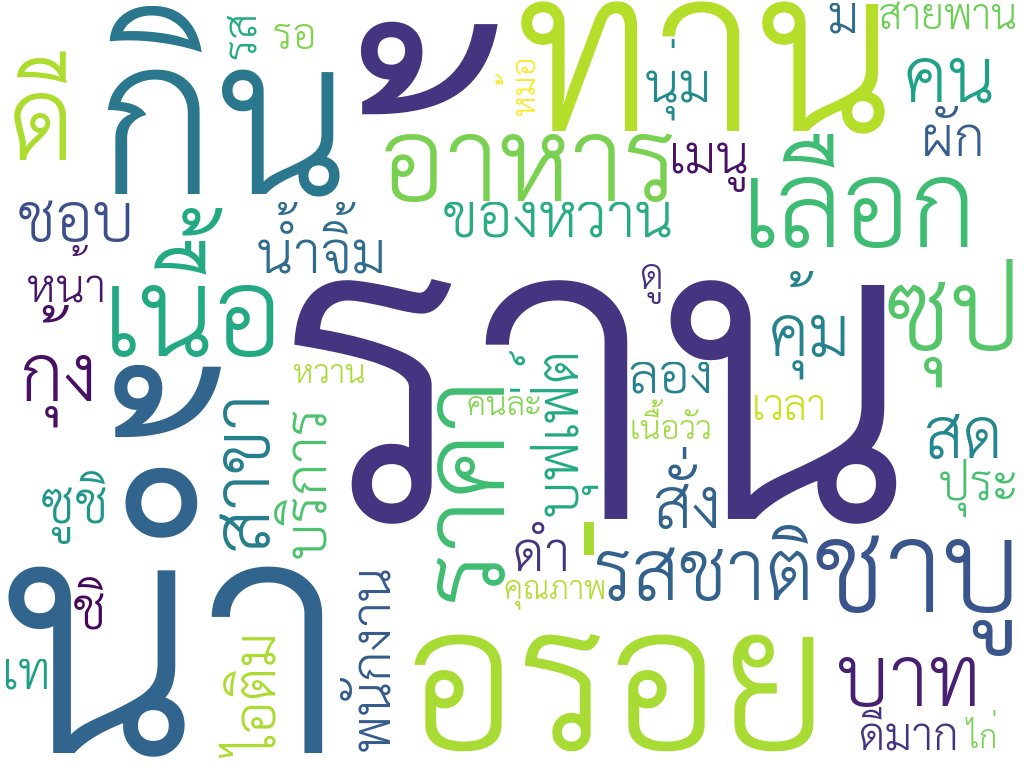

In [11]:
# Import the wordcloud library
from wordcloud import WordCloud
from os import path
!wget -q http://www.arts.chula.ac.th/ling/wp-content/uploads/TH-Sarabun_Chula1.1.zip -O font.zip
!unzip -qj font.zip TH-Sarabun_Chula1.1/THSarabunChula-Regular.ttf
!apt install fonts-thai-tlwg
# Join the different processed titles together.
long_string = ' '.join(df['Review_tokenized'].values)
# # Create a WordCloud object
# WordCloud(font_path='THSarabunNew.ttf',
#                       background_color="white",
#                       width=1024, # กว้าง
#                       height=768, # ยาว
#                       collocations=False,
#                       regexp=r"[\u0E00-\u0E7Fa-zA-Z']+"
#                       ).generate(' '.join(df['Review_tokenized'].values()))
wordcloud = WordCloud(background_color="white", max_words=50, contour_width=1, contour_color='steelblue',font_path='THSarabunChula-Regular.ttf',
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+", collocations=False,width=1024,height=768) 
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


# Text to Emotion

In [12]:
df2 = df
df2['Trans'] = df2['Review'].apply(lambda x: ThEnTranslator().translate(x))
df2['Emotion'] = df2['Trans'].apply(lambda x: te.get_emotion(x))
df2[['Review','Trans','Emotion']].head()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


,Review,Trans,Emotion
0,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,What's important about this restaurant is very...,"{'Happy': 0.45, 'Angry': 0.05, 'Surprise': 0.0..."
1,นึกถึงชาบูญี่ปุ่นยังไงก็ต้อง คิดถึงโมโม่ พาราไ...,Think of Japanese shabu tea anyways. Think of ...,"{'Happy': 0.32, 'Angry': 0.0, 'Surprise': 0.21..."
2,มาทานช่วงนี้ สามารถนั่งโต๊ะเดียวกัน หม้อเดียวก...,You can sit at the same table with the same po...,"{'Happy': 0.06, 'Angry': 0.11, 'Surprise': 0.0..."
3,ถ้านึกถึงชาบูที่มีเนื้อเน้นๆ ในราคาไม่โหดจนเกิ...,If you're thinking about a full-on teabu at an...,"{'Happy': 0.12, 'Angry': 0.12, 'Surprise': 0.5..."
4,เดินมาหน้าร้านแล้วได้กลิ่นชาบูหอมมาก ๆ ประกอบ...,Walked up to the store and smelled a lot of ch...,"{'Happy': 0.25, 'Angry': 0.0, 'Surprise': 0.0,..."


# Create Dictionary



In [13]:
documents = df['Review_tokenized'].to_list()
texts = [[text for text in doc.split(',')] for doc in documents]
texts = [x for x in texts if (x not in removed_words)]
dictionary = gensim.corpora.Dictionary(texts)

print(dictionary.token2id.keys())

dict_keys(['1', '4', '560', 'กิน', 'ข้างนอก', 'ความต้องการ', 'คอ', 'คุณภาพ', 'คุณภาพดี', 'คุ้ม', 'จำกัด', 'ซุป', 'ดำ', 'ดี', 'ดีมาก', 'ถาด', 'ถาม', 'น่ารัก', 'น้ำ', 'น้ำจิ้ม', 'บริการ', 'บาท', 'ประทับใจ', 'พนักงาน', 'พอกับ', 'รสชาติ', 'ราคา', 'ร้าน', 'สรุป', 'สะอาดสะอ้าน', 'สัน', 'หลากหลาย', 'อร่อย', 'อันนี้', 'อาหาร', 'เคลม', 'เซ็ท', 'เต้าเจี้ยว', 'เนื้อ', 'เป็ด', 'เผ็ด', 'แบบนี้', 'แปลกใหม่', 'แฟน', 'โดยรวม', 'โมจิ', 'ใส่ใจ', 'ไม่ต้อง', 'ไอติม', '21', '30', '9', 'CTW', 'Terminal', 'กา', 'การงด', 'คิดถึง', 'ชาบู', 'ญี่ปุ่น', 'ฐาน', 'ทะยอย', 'ทำงาน', 'ที่ทาง', 'นาที', 'นึกถึง', 'พนักงานบริการ', 'พระราม', 'พรีเมียม', 'พาราไดซ์', 'มาตรา', 'มีโอ', 'รายละเอียด', 'ลูกค้า', 'สมาทาน', 'สาขา', 'สู้', 'ออร์เดอร์', 'เครื่องดื่ม', 'เค้า', 'เจอ', 'เป็นกันเอง', 'เหวี่ยง', 'แจ้ง', 'โมโม่', 'โอเค', '++', '2', '555', '600', '::', 'กก', 'กรุบ', 'กั้น', 'ของหวาน', 'คนละ', 'คาว', 'คุ', 'คุ้มค่า', 'จาน', 'จิ้ม', 'จืด', 'ฉาก', 'ชอบ', 'ชาเขียว', 'ชิ้น', 'ซอย', 'ซอส', 'ตก', 'ตะ', 'ตัก', 'ตามน้ำ', 'ต่างกัน', 

In [14]:
gensim_corpus = [dictionary.doc2bow(text, allow_update=True) for text in texts]
word_frequencies = [[(dictionary[id], frequence) for id, frequence in couple] for couple in gensim_corpus]

In [15]:
num_topics = 4
chunksize = 1000 # size of the doc looked at every pass
passes = 100 # number of passes through documents
iterations = 100
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every, per_word_topics=True )

In [16]:
df['topics'] = df['Review_tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][0])
df['score'] = df['Review_tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][1])
df[['Review','topics','score']].tail()

,Review,topics,score
16,หลังจากที่เคยลองสาขายูเนี่ยนมอลล์ไป รอบนี้มาที...,0,0.999468
17,ร้านบุฟเฟ่ต์ที่มีโปรโมชั่นหัวละ199บาท ไม่รวมน้...,3,0.999407
18,เคยรู้จักร้านนี้จากที่ union mall ไม่เคยได้ลอง...,2,0.999425
19,อร่อยมากค่ะ คุ้มค่าสมราคา บุฟเฟ่หมูผักต่างๆ รว...,3,0.999221
20,ก็ตามที่เขียนเลยครับ ว่า ถ้าจะจ่ายในราคา 199 บ...,3,0.998726


# Display Topic Model

In [17]:
vis = pyLDAvis.gensim_models.prepare(model, gensim_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.003584 -0.085065       1        1  38.397467
0      0.093699  0.062166       2        1  30.691991
3     -0.104192  0.054554       3        1  26.944810
1      0.014077 -0.031655       4        1   3.965732, topic_info=     Term       Freq      Total Category  logprob  loglift
268  กุ้ง   8.000000   8.000000  Default  30.0000  30.0000
331     -  11.000000  11.000000  Default  29.0000  29.0000
286    เท   3.000000   3.000000  Default  28.0000  28.0000
279     ม   3.000000   3.000000  Default  27.0000  27.0000
277  ปุระ   3.000000   3.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
102   ชอบ   0.334407   6.927690   Topic4  -5.1035   0.1966
236  เมนู   0.334407   5.420478   Topic4  -5.1035   0.4419
271    ชิ   0.334407   6.307632   Topic4  -5.1035   0.2903
272  ซูชิ   0.334407   6.092374   Topic4  -5.1035   0.3250
300   ตัว   0.334407   3.108039   Topic4  -5.1035   0.9981

[244 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
208       3  0.723916      +
85        3  0.747787     ++
331       2  0.939819      -
209       3  0.723916      /
332       2  0.733570    /คน
...     ...       ...    ...
165       3  0.975602    ไม้
330       1  0.915950   ไลน์
48        1  0.329682  ไอติม
48        2  0.329682  ไอติม
48        3  0.329682  ไอติม

[252 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

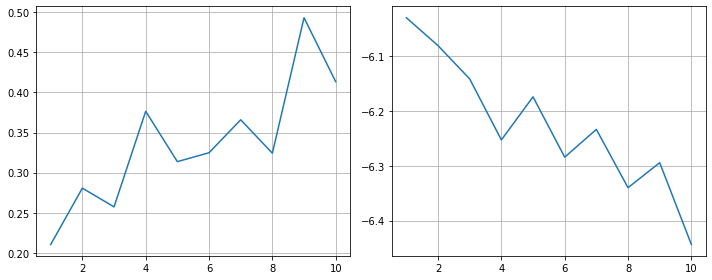

In [18]:
score = []
for k in range(1,11):
    model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, 
                        alpha='auto', eta='auto', 
                        iterations=iterations, num_topics=k, 
                        passes=passes, eval_every=eval_every)
    coherence_model_lda = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    score.append((k,coherence_model_lda.get_coherence(),model.log_perplexity(gensim_corpus)))

x, y, z = zip(*score)
plt.figure(figsize=(10,4), tight_layout=True)
plt.subplot(121)
plt.plot(x, y, label='Coherence')
plt.grid(True)
plt.subplot(122)
plt.plot(x, z, label='perplexity')
plt.grid(True)
plt.show()